In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Objectif
- prédire le temps de retard moyen des trains sur une ligne sur un mois
--> predire retard_moyen_arrivee? ou retard_moyen_tous_trains_arrivee?
- prédire la cause du retard (en pourcentage pour chaque cause potentielle) sur une ligne sur un mois

- alternative --> fusionner toutes les lignes sur un mois et predire sur un mois pour toute les lignes à la fois

## Questions

### faire deux modèles distincts ou dépendants pour ces deux problématique?
- si dépendant --> NN avec une regression et des classifs en sortie
- si indépendant --> on a le choix
- mix --> on prédit la regression d'abord puis la classif en se servant des resultats de la regression ( ou inversement)

### Modèles independants pour chaque ligne de train ou tout lier?
- si indépendant, plus facile à gérer on peut facilement créer des séries temporelles, mais beaucoup(beaucoup) de modèle à créer
- si liée, on peut exploiter des correlations en plus et on n'a qu'un modèle, mais on doit encoder l'année, le mois et toutes les gares (avec un one hot ça va faire beaucoup de colonne, avec un ordinal on introduit une relation d'ordre qui n'existe pas, remarque on aurait pas ce soucis avec des arbres de décision)

### Analyse à faire 
- autocorrelation mois et année sur le temps de retard et les causes du retard
- regarder correlation retard moyen entre paris-lyon et lyon-paris (pour tout les couples de gares)
- pleins d'autres trucs qui nous permettront d'enlever/modifier/rajouter des colonnes

### Données qu'on peut rajouter
- longueur de chaque lignes (pas forcement nécessaire?)
- nombre d'habitants dans chaques ville

### Infos importantes
- https://www.data.gouv.fr/fr/datasets/regularite-mensuelle-tgv-par-liaisons/

In [3]:
df = pd.read_csv("regularite-mensuelle-tgv-aqst.csv",encoding="latin-1")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8154 entries, 0 to 8153
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  8154 non-null   object 
 1   service                               8154 non-null   object 
 2   gare_depart                           8154 non-null   object 
 3   gare_arrivee                          8154 non-null   object 
 4   duree_moyenne                         8154 non-null   int64  
 5   nb_train_prevu                        8154 non-null   int64  
 6   nb_annulation                         8154 non-null   int64  
 7   commentaire_annulation                0 non-null      float64
 8   nb_train_depart_retard                8154 non-null   int64  
 9   retard_moyen_depart                   8154 non-null   float64
 10  retard_moyen_tous_trains_depart       8154 non-null   float64
 11  commentaire_retar

In [46]:
df.tail()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
8149,6/1/2023,National,STRASBOURG,PARIS EST,114,492,2,NaN,273,11.989927,...,80,35.446667,31,10,7.619048,5.714286,55.238095,18.095238,7.619048,5.714286
8150,6/1/2023,National,TOULOUSE MATABIAU,PARIS MONTPARNASSE,273,215,0,NaN,24,28.730556,...,36,76.688889,24,10,13.888889,33.333333,8.333333,19.444444,8.333333,16.666667
8151,6/1/2023,National,TOURS,PARIS MONTPARNASSE,78,192,1,NaN,20,31.281667,...,13,97.394872,7,5,14.285714,21.428571,28.571429,21.428571,3.571429,10.714286
8152,6/1/2023,National,VALENCE ALIXAN TGV,PARIS LYON,133,440,2,NaN,347,13.517051,...,96,47.424479,62,22,26.724138,19.827586,27.586207,7.758621,7.758621,10.344828
8153,6/1/2023,National,VANNES,PARIS MONTPARNASSE,167,284,0,NaN,154,6.480628,...,34,49.740686,17,7,11.627907,39.534884,11.627907,18.604651,11.627907,6.976744


In [6]:
print(len(set(df["gare_depart"].tolist()))) #pd.get_dummies
print(len(set(df["gare_arrivee"].tolist()))) #pd.get_dummies
print(len(df["date"].tolist())) 

59
59
8154


In [9]:
for col in df.columns:
    print(col)

date
service
gare_depart
gare_arrivee
duree_moyenne
nb_train_prevu
nb_annulation
commentaire_annulation
nb_train_depart_retard
retard_moyen_depart
retard_moyen_tous_trains_depart
commentaire_retards_depart
nb_train_retard_arrivee
retard_moyen_arrivee
retard_moyen_tous_trains_arrivee
commentaires_retard_arrivee
nb_train_retard_sup_15
retard_moyen_trains_retard_sup15
nb_train_retard_sup_30
nb_train_retard_sup_60
prct_cause_externe
prct_cause_infra
prct_cause_gestion_trafic
prct_cause_materiel_roulant
prct_cause_gestion_gare
prct_cause_prise_en_charge_voyageurs


In [15]:
set(df["gare_depart"].tolist()) == set(df["gare_arrivee"].tolist())

True

In [24]:
Lstations = list(set(df["gare_depart"].tolist()))
Lstations.sort()
stations = {station:i for i, station in enumerate(Lstations)}

{'AIX EN PROVENCE TGV': 0,
 'ANGERS SAINT LAUD': 1,
 'ANGOULEME': 2,
 'ANNECY': 3,
 'ARRAS': 4,
 'AVIGNON TGV': 5,
 'BARCELONA': 6,
 'BELLEGARDE (AIN)': 7,
 'BESANCON FRANCHE COMTE TGV': 8,
 'BORDEAUX ST JEAN': 9,
 'BREST': 10,
 'CHAMBERY CHALLES LES EAUX': 11,
 'DIJON VILLE': 12,
 'DOUAI': 13,
 'DUNKERQUE': 14,
 'FRANCFORT': 15,
 'GENEVE': 16,
 'GRENOBLE': 17,
 'ITALIE': 18,
 'LA ROCHELLE VILLE': 19,
 'LAUSANNE': 20,
 'LAVAL': 21,
 'LE CREUSOT MONTCEAU MONTCHANIN': 22,
 'LE MANS': 23,
 'LILLE': 24,
 'LYON PART DIEU': 25,
 'MACON LOCHE': 26,
 'MADRID': 27,
 'MARNE LA VALLEE': 28,
 'MARSEILLE ST CHARLES': 29,
 'METZ': 30,
 'MONTPELLIER': 31,
 'MULHOUSE VILLE': 32,
 'NANCY': 33,
 'NANTES': 34,
 'NICE VILLE': 35,
 'NIMES': 36,
 'PARIS EST': 37,
 'PARIS LYON': 38,
 'PARIS MONTPARNASSE': 39,
 'PARIS NORD': 40,
 'PARIS VAUGIRARD': 41,
 'PERPIGNAN': 42,
 'POITIERS': 43,
 'QUIMPER': 44,
 'REIMS': 45,
 'RENNES': 46,
 'SAINT ETIENNE CHATEAUCREUX': 47,
 'ST MALO': 48,
 'ST PIERRE DES CORPS': 49,


In [61]:
idx = 3466
print(df["nb_annulation"][idx])
print(df["nb_train_prevu"][idx])
print((df["nb_annulation"][idx]/(df["nb_train_prevu"][idx]+df["nb_annulation"][idx])))

2
0
1.0


C:\Users\asus\AppData\Local\Temp\ipykernel_18340\2994318915.py:9: RuntimeWarning: invalid value encountered in scalar divide
  perc_cancel = (df["nb_annulation"][idx]/(df["nb_train_prevu"][idx]+df["nb_annulation"][idx]))


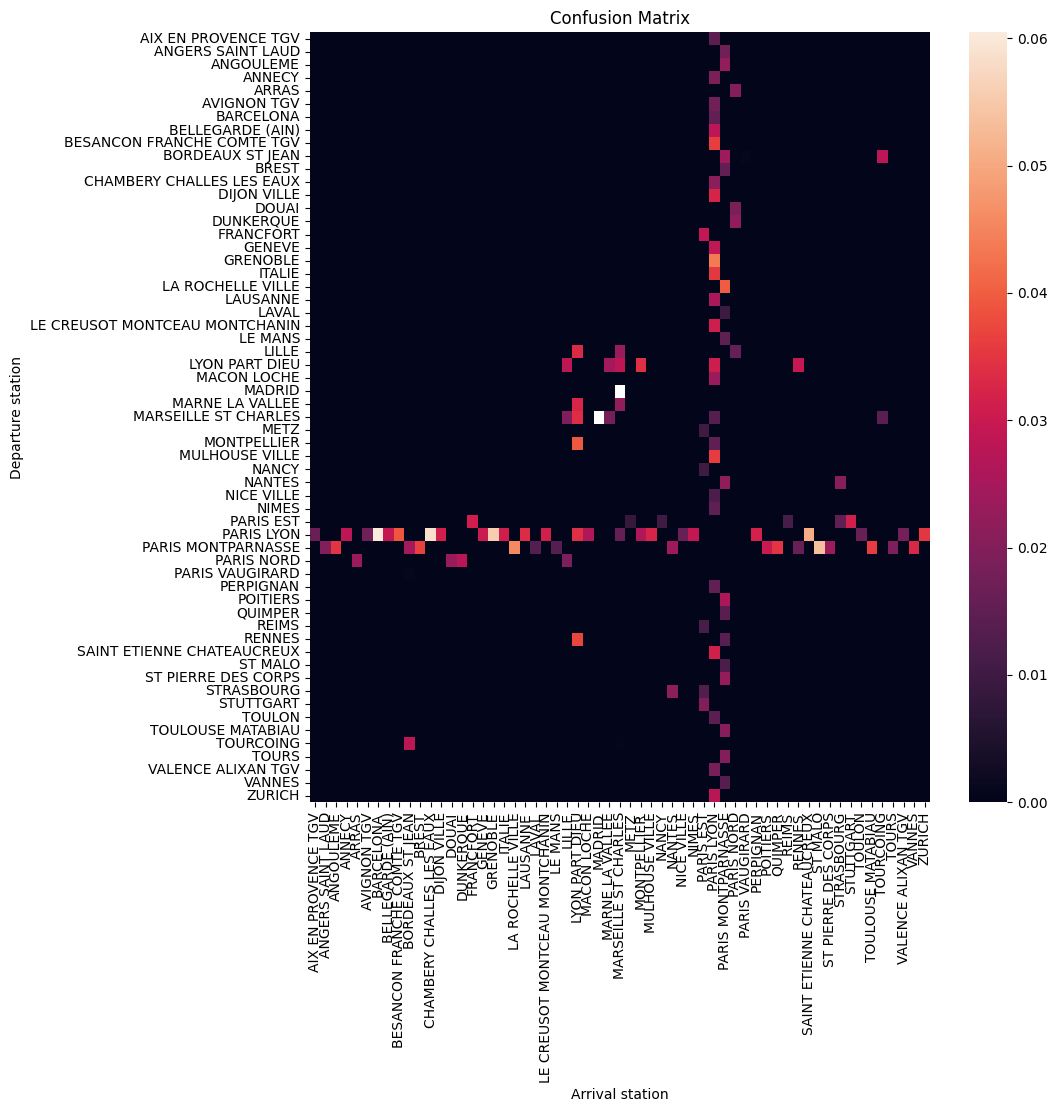

In [62]:

cancel_arr = np.zeros((len(stations), len(stations)))

for idx in df.index:
    departure = stations[df["gare_depart"][idx]]
    arrival = stations[df["gare_arrivee"][idx]]

    perc_cancel = (df["nb_annulation"][idx]/(df["nb_train_prevu"][idx]+df["nb_annulation"][idx]))
    # if df["nb_annulation"][idx]>df["nb_train_prevu"][idx]:
    #     print(idx)
    if cancel_arr[departure, arrival] == 0:
        cancel_arr[departure, arrival] = perc_cancel
    else:
        cancel_arr[departure, arrival] = (perc_cancel + cancel_arr[departure, arrival])/2



plt.figure(figsize=(10,10))
ax= plt.subplot()
sns.heatmap(cancel_arr, xticklabels=Lstations, yticklabels=Lstations, annot=False, ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Arrival station')
ax.set_ylabel('Departure station')
ax.set_title('Confusion Matrix')
# ax.xaxis.set_ticklabels(classes)
# ax.yaxis.set_ticklabels(classes)

plt.show()

Make a line plot over 12 months with curves for every years

In [ ]:
def get_delay_by_month(df):
    
    for i, d in enumerate(df["date"].tolist()):
        month, day, year = d.split('/')
        

In [74]:
def clean_df(df):
    # Add commands to clean dataframe
    df = df.dropna(axis=1, how='all')
    df = df.drop("commentaires_retard_arrivee", axis=1) # str and not relevant for model
    return df

clean_df = clean_df(df) #Test
# Dataset cleaning should be done on train and test set separately -> ensure reproducibility


In [75]:
print(len(clean_df.columns))
print(len(df.columns))

23
26


In [55]:
def get_train_test_set(df):
    train_idx = []
    test_idx = []
    for i, d in enumerate(df["date"].tolist()):
        month, day, year = d.split('/')
        if int(year)<2023:
            train_idx.append(i)
        else:
            test_idx.append(i)
    
    train_set = df.iloc[train_idx].copy(deep=True)
    test_set = df.iloc[test_idx].copy(deep=True)
    
    return train_set, test_set

train_set, test_set = get_train_test_set(df)


split = [(len(train_idx)/len(df))*100, (len(test_idx)/len(df))*100]
print(f"Lenghts of train/test: {len(train_idx)}/{len(test_idx)}")
print(f"split train/test: {round(split[0],2)}/{round(split[1],2)}")

Lenghts of train/test: 7428/726
split train/test: 91.1/8.9


In [53]:
set(train_set["service"].tolist())

{'International', 'National'}

test with date transform to year, months over years, days